### Nueral Machine Translation

In this notebook we are going to create a nueral machine translation model that translate sequencial text from 1 domain to the other domain.

I will be following [this](https://blog.paperspace.com/neural-machine-translation-with-tensorflow/) tutorial to bring my code to live. 

### Imports.


In [1]:
import tensorflow as tf
import numpy as np

import os, time, random, math

from tensorflow import keras
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


### Data Loading and preprocessing

I've already downloaded [this](https://www.manythings.org/anki/fra-eng.zip
) dataset and unzip it and uploaded it on my google drive as uasual.

### Paths

In [2]:
base_path = "/content/drive/My Drive/NLP Data/seq2seq/data/eng-fra.txt"

### Checking the first line in the corpus.

In [3]:
lines = open(base_path, encoding="utf8").read().split('\n')
lines[0]

'Go.\tVa !'

### Creating a `Lang` class

Let's create a class, for each language that is going to map each word in a language to a unique integer number. 

This class is going to have three dictionary data structures, one to map each word to a unique integer, one to map an integer to a word and the third, to map a word to its total number in the corpus. 

The class is going to have two important functions to add words from the corpus to their class dictionaries. 

In [4]:
class Lang:
  def __init__(self, name):
    self.name = name
    self.stoi = {} # string to intenger
    self.stof = {} # string to frequence
    self.itos = {0 : "<sos>", 1 : "<eos>", 2: "<unk>"}  # integer to string
    self.word_count = 3 # initial tokens are 3, <sos>,...

  def addWord(self, word):
    if word not in self.stoi:
      self.stoi[word] = self.word_count
      self.stof[word] = 1
      self.itos[self.word_count] = word
      self.word_count += 1
    else:
      self.stof[word] += 1

  def addSentence(self, sentence):
    # Next time we will use tokenizers.
    for word in sentence.split(" "):
      self.addWord(word)
      

### A step futher.
Our corpus consists of French words which may have some characters like ‘Ç’. For simplicity sake, we convert them into their normal corresponding ASCII characters(Ç → C). Also we create white spaces between words and punctuation attached to these words . (hello’s → hello s). This is to ensure that the presence of a punctuation does not create two words for a particular word (difference integers would be assign to “they’re” and they are).


In [5]:
import unicodedata, re

def unicodeToAscii(s):
  return "".join(c for c in unicodedata.normalize("NFD", s) \
                  if unicodedata.category(c) != "Mn")
    
def normalizeString(s):
  s = unicodeToAscii(s.lower().strip())
  s = re.sub(r"([!.?])", r" \1", s)
  s = re.sub(r"[^a-zA-Z?.!]+", " ", s)
  return s

### Loading the dataset.
Now let's combine these two helper functions and load the dataset containing the pairs of sentences.

In [6]:
def load_dataset(path):
  lines = open(base_path, encoding="utf8").read().split('\n')
  return [[normalizeString(pair) for pair in 
              line.strip().split('\t')] for line in lines]

In [7]:
pairs = load_dataset(base_path)
pairs[:2]

[['go .', 'va !'], ['run !', 'cours !']]

To reduce the training time for our demonstration, we are going to filter out our dataset to remove sentences with more than ten words. We can achieve that with the functions below which iterates through our pairs and removes pairs which have sentences containing more than ten words.

In [8]:
MAX_LENGTH = 10
def filterPair(p):
    return len(p[0].split()) < MAX_LENGTH and len(p[1].split()) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]
    

### Converting strings to numbers representaion.



In [9]:
SOS = 0
EOS = 1
UNK = 2

def sentencetoIndexes(sentence, lang):
    indexes = [lang.stoi[word] for word in sentence.split()]
    indexes.append(EOS)
    return indexes

Next, we are going to populate our `stoi` disctionary for each language class with words and assign a correcponding integer to each word ina a new function. Also we are going to batch our dataset and apply padding to sentences with words less than the maximum length of 10.

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
def build_lang(lang1, lang2, max_length=10):
  input_lang = Lang(lang1)
  output_lang = Lang(lang2)
  input_seq = []
  output_seq = []
  for pair in pairs:
    try:
      input_lang.addSentence(pair[1])
      output_lang.addSentence(pair[0])
    except:
      pass

  for pair in pairs:
    try:
      input_seq.append(sentencetoIndexes(pair[1], input_lang))
      output_seq.append(sentencetoIndexes(pair[0], output_lang))
    except:
      pass
  return pad_sequences(input_seq, maxlen=max_length, padding='post', truncating='post'), pad_sequences(output_seq, padding='post', truncating='post'), input_lang, output_lang


In [11]:
input_tensor, output_tensor, input_lang, output_lang = build_lang('fr',
                                                                  'en')

In [12]:
print("input_tensor at index 10: {}".format(input_tensor[10]))
print("output_tensor at index 10: {}".format(output_tensor[10]))
print("corresponding integer value for 'nous' {}".format(input_lang.stoi['nous']))
print("corresponding integer value for 'she' {}".format(output_lang.stoi['she']))

input_tensor at index 10: [20  4  1  0  0  0  0  0  0  0]
output_tensor at index 10: [12  6  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0]
corresponding integer value for 'nous' 83
corresponding integer value for 'she' 158


### Creating data batches.


In [13]:
BUFFER_SIZE = len(input_tensor)
BATCH_SIZE = 16

dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor, output_tensor)
).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### Building the `Seq2Seq` model.

> There are several architectures of Recurrent Neural Networks, each suited for a particular group of tasks. Some examples are many-to-one architecture for task such as sentiment analysis and one-to-many for music generation but we are going to employ the many-to-many architecture which is suited for tasks such as chat-bots and of course Neural Machine Translation.

<p align="center"><img src="https://blog.paperspace.com/content/images/2019/08/image-3.png"/>

<center>
<strong align="center">Different <i>RNN</i> acticectures</strong>
</center>
</p>

> As you can see from the image above, there are two types of many-to-many architectures but we are going to use the first one which consist of two networks: one to take in the input sentence and the other to translate into another language in the case of machine translation. This architecture is suitable for our task because we have inputs and outputs with different lengths. This special class of architecture is called a Sequence to Sequence model. The network where the input is encoded is called the Encoder. The other network is called the decoder since it receives a fixed size vector from the encoder to decode the outputs.t sentence. The minds behind this architecture are Ilya Sutskever, Oriol Vinyals and Quoc V. Le.  Link to paper: https://arxiv.org/pdf/1409.3215.pdf


### Attention Mechanism

Later that same year when Sutskever and his team proposed their sequence to sequence architecture, several efforts were made to surmount the bottleneck in Sutskever’s model. One major breakthrough that caught the attention of many was the work of Yoshua Bengio and some others in the paper titled Neural Machine Translation by Jointly Learning to Align and Translate. The basic idea behind this architecture is that whenever the decoder is generating a particular output word, it considers information about all the words in the input sentence and determines which words in the inputs sentence are relevant to generate the correct output word. In a sequence model, the common way to pass information about the data at a particular time-step to the next time-step is through the hidden states. This means each hidden state at a particular time-step in our model has some information about the word at that time-step. It does make sense that not every word in the input sentence is required to generate a particular word in the output sentence. For example, when we humans want to translate the french sentence "Je suis garcon" to "I am a boy", obviously when we are translating the word "boy", intuitively we would be paying more attention to the word "garcon" than any other word in our input french sentence. That is exactly how attention mechanism in a sequence to sequence model works - our decoder pays attention to a particular word or group of words when generating a particular word. You probably might be wondering how our decoder network pays attention to words. Well it uses connections or weights. The greater the connection or weight to a particular word in the input sentence, the more our decoder is paying attention to that word. We also ought to know that our weights should be a function of the hidden state immediately before the time step we are decoding ( this gives the decoder information about already decoded words) and the encoder outputs but we don’t know what that function is so we let back-propagation take over to learn the appropriate weights. We also ensure that all weights mapping all words in the input sentence to a particular word in the output sentence add up to one. This is asserted using a softmax function. Now that we have some basic idea of attention mechanism, let’s go ahead and implement our model. We’ll start with the encoder. (Does not employ attention mechanism).

### Encoder

The Encoder is usually very easy to implement. It’s made up of two layers: the Embedding layer which converts each token(word) into a dense representation and a Recurrent Network layer.



In [15]:
class Encoder(keras.Model):
  def __init__(self,vocab_size,
               num_hidden=256,
               num_embedding=256, 
               batch_size=16
               ):
    super(Encoder, self).__init__()
    self.batch_size = batch_size
    self.num_hidden = num_hidden
    self.num_embedding = num_embedding
    self.embedding = keras.layers.Embedding(vocab_size, num_embedding)
    self.gru = keras.layers.GRU(num_hidden,
                                return_sequences=True, # very important
                               recurrent_initializer='glorot_uniform',
                                return_state=True # very important
                             )
  def call(self, x, hidden):
    embedded = self.embedding(x)
    rnn_out, hidden = self.gru(embedded, initial_state=hidden)
    return rnn_out, hidden

  def init_hidden(self):
    return tf.zeros(shape=(self.batch_size, self.num_hidden))

In [16]:
inputs, outputs = next(iter(dataset))
hidden = tf.zeros((16, 256))

In [17]:
encoder = Encoder(input_lang.word_count)

In [18]:
e_outputs, e_hidden = encoder(inputs, hidden)
e_hidden

<tf.Tensor: shape=(16, 256), dtype=float32, numpy=
array([[-0.00549383,  0.00859579,  0.02028259, ..., -0.00107742,
         0.0179934 ,  0.01089506],
       [ 0.00920012,  0.01402   ,  0.01171976, ..., -0.0044369 ,
         0.01388076, -0.00042458],
       [-0.01438294, -0.00073432,  0.00790572, ...,  0.01442005,
         0.01272794, -0.00554024],
       ...,
       [ 0.02305173,  0.02369477,  0.00135033, ..., -0.00722299,
         0.01104399, -0.01294329],
       [ 0.03167223, -0.0097674 ,  0.0169453 , ...,  0.00436738,
        -0.00440438,  0.00045385],
       [ 0.00714136,  0.0130656 ,  0.01286327, ..., -0.0051284 ,
         0.00948083,  0.00018757]], dtype=float32)>

In teh GRU implementation: return_sequences and return_state. return_sequences ensures that the GRU outputs the hidden state of each time step. Remember that we need this information to access information about each word in the input sequence. Return state returns the hidden state of the last time step. We need this tensor to be used as initial hidden state for the decoder.

### Decoder 
Unlike the Encoder, the Decoder is a bit complex. It has in addition to the Embedding and Gated Recurrent Network layer an Attention layer and a fully connected layer. 


In [19]:
class BahdanauAttention(keras.models.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = keras.layers.Dense(units)
    self.W2 = keras.layers.Dense(units)
    self.V = keras.layers.Dense(1)
      
  def call(self, encoder_out, hidden):
    #shape of encoder_out : batch_size, seq_length, hidden_dim (16, 10, 1024)
    #shape of encoder_hidden : batch_size, hidden_dim (16, 1024)
    hidden = tf.expand_dims(hidden, axis=1) #out: (16, 1, 1024)
    score = self.V(tf.nn.tanh(self.W1(encoder_out) + \
                              self.W2(hidden))) #out: (16, 10, 1)
    attn_weights = tf.nn.softmax(score, axis=1)
    context =  attn_weights * encoder_out #out: ((16,10,1) * (16,10,1024))=16, 10, 1024
    context = tf.reduce_sum(context, axis=1) #out: 16, 1024
    return context, attn_weights
    

In [20]:
attn = BahdanauAttention(256)

In [21]:
context, attn_weights = attn(e_outputs, e_hidden)

In [22]:
attn_weights.shape

TensorShape([16, 10, 1])

It seems pretty simple to implement but you really need to pay attention to the dimensions as data moves through the pipeline. The call function where forward propagation takes place takes in two parameters; encoder_out which represents all the hidden states at each timestep in the encoder and hidden which represents the hidden state before the current timestep where we are generating the correct word.

Since the hidden is the hidden state of a timestep in the decoder, we add a dimension of size 1 to represent the timestep hence shape of hidden becomes (batch_size, time_step, hidden_size). Earlier, we mentioned that the weights for determining attention for a particular word are a function of the hidden_state immediately before that timestep in the decoder and all the hidden_states(encoder_out) of the encoder. That is exactly what we implemented and assigned to score in the code above. We then apply softmax to score across the max_length dimension which is at axis=1. Let’s see a visual explanation.

![img](https://blog.paperspace.com/content/images/2019/08/image-11.png)

From the diagram above, hi and zj represent all hidden states of encoder and hidden state immediately before the timestep we are in the decoder respectively.The end product of the softmax function gives us the weights which we multiply with all the hidden states from the encoder. A hidden state at a particular timestep with a bigger weight value means more attention is being paid on the word at that timestep. You may have noticed we performed a reduce_sum to produce the context vector. After multiplying each hidden_state with its corresponding weight, we combine all resultant values through a summation. That's it for the attention layer. It returns the context vector and the attention weights.



In [23]:
class Decoder(keras.models.Model):
  def __init__(self, 
                vocab_size, 
                dec_dim=256, 
                embedding_dim=256
                ):
      super(Decoder, self).__init__()
      self.attn = BahdanauAttention(dec_dim)
      self.embedding = keras.layers.Embedding(vocab_size, 
                                              embedding_dim
                                              )
      self.gru = keras.layers.GRU(dec_dim, 
                                  recurrent_initializer='glorot_uniform',
                                  return_sequences=True, 
                                  return_state=True)
      self.fc = keras.layers.Dense(vocab_size)
        
  def call(self, x, hidden, enc_out):
    # x.shape = (16, 1)
    # enc_out.shape = (16, 10, 256)
    # enc_hidden.shape = (16, 256)
    x = self.embedding(x)
    # x.shape = (16, 1, 256)
    context, attn_weights = self.attn(enc_out, hidden)
    # context.shape = (16, 256)
    x = tf.concat((tf.expand_dims(context, 1), x), -1)
    # x.shape = (16, 1, e_c_hidden_size + d_c_embedding_size)
    r_out, hidden = self.gru(x, initial_state=hidden)
    out = tf.reshape(r_out,shape=(-1, r_out.shape[2]))
    # out.shape = (16, 256)
    return self.fc(out), hidden, attn_weights

In [24]:
decoder = Decoder(output_lang.word_count)
input_tensor, output_tensor = next(iter(dataset))
x = np.expand_dims(output_tensor[:,1], -1)

In the call function, we pass in three parameters, x representing the tensor of a single word, hidden which represents the hidden state of the previous timestep and enc_out which represents all the hidden states of the encoder,  we pass x through an embedding layer which maps the single integer token into a dense 256 dimensional vector and concatenate it with the context vector generated by the attention layer. The resultant tensor becomes our input for the Gated Recurrent Network for a single timestep. Finally we pass the output of the GRU through a fully connected layer which outputs a vector of size (batch_size, number of english words). We also return hidden state to be fed into the next timestep and the attention weights for later visualizations. Our complete model is now ready to be trained. 

### Loss functions

In [25]:
def loss_fn(real, pred):
  criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  _loss = criterion(real, pred)
  mask = tf.cast(mask, dtype=_loss.dtype)
  _loss *= mask
  return tf.reduce_mean(_loss)
  

We use keras’s sparse categorical cross entropy module since we have a large number of categories(number of english words). We create a mask that asserts that the padding tokens are not included in calculating the loss.Now let’s dive in into our training pipeline

In [26]:
optimizer = tf.optimizers.Adam()

In [27]:
def train_step(input_tensor, target_tensor, enc_hidden):
  loss = 0.0
  with tf.GradientTape() as tape:
    batch_size = input_tensor.shape[0]
    enc_output, enc_hidden = encoder(input_tensor, enc_hidden)

    SOS_tensor = np.array([SOS])
    dec_input = tf.squeeze(tf.expand_dims([SOS_tensor]*batch_size, 1), -1)
    dec_hidden = enc_hidden

    for tx in range(target_tensor.shape[1]-1):
      dec_out, dec_hidden, _ = decoder(dec_input, dec_hidden,
                                      enc_output)
      loss += loss_fn(target_tensor[:, tx], dec_out)
      dec_input = tf.expand_dims(target_tensor[:, tx], 1)

  batch_loss = loss / target_tensor.shape[1]
  t_variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, t_variables)
  optimizer.apply_gradients(zip(gradients, t_variables))
  return batch_loss

In [28]:
hidden = tf.zeros(shape=(16, 256))
loss = train_step(input_tensor, output_tensor, hidden)
print(loss)

tf.Tensor(1.4865503, shape=(), dtype=float32)


The above snippet implements a single training step. In our single training step, we pass the input_tensor which represent the input sentence through the forward propagation pipeline of the Encoder. This return the enc_output(hidden_state of all timesteps) and enc_hidden(last hidden_state). Notice that the last hidden_state of the encoder is used as the initial hidden_state of the decoder. In the decoding part, we use a technique called teacher forcing where instead of using the predicted word as input for the next timestep, we use the actual word. At the start of decoding, we feed the Start Of Sentence token as input and maximize the probability of the decoder predicting the first word in the output sequence as it output. We then take the actual first word and feed it into the second timestep and maximize the probability of the decoder predicting the second word in the output sequence as it output. This continues sequentially until we reach the End of Sentence token<EOS>. We accumulate all the losses, derive the gradients and train both networks end-to-end with the gradients. That’s all it takes to complete a single training step. Let’s implement a helper function to save our model at certain points during our training.

In [31]:
def checkpoint(model, name=None):
  if name is not None:
    model.save_weights('/content/drive/My Drive/{}.h5'.format(name))
  else:
    raise NotImplementedError

The final part of our training pipeline is a training loop. It’s pretty simple to understand. All we do is to run through some epochs and at each epoch, we iterate through our dataset and call the train_step function on each batch of the dataset. There are some if-else statements just to log our training statistics on screen. Let’s see how.



In [ ]:
EPOCHS = 10
log_every = 50
steps_per_epoch = len(pairs) # BATCH_SIZE
for e in range(1, EPOCHS):
  total_loss = 0.0
  enc_hidden = encoder.init_hidden()
  for idx, (input_tensor, target_tensor) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(input_tensor, target_tensor, hidden)
    total_loss += batch_loss
    if idx % log_every == 0:
        print("Epochs: {} batch_loss: {:.4f}".format(e, batch_loss))
        checkpoint(encoder, 'encoder')
        checkpoint(decoder, 'decoder')   
  if e % 2 == 0:
      print("Epochs: {}/{} total_loss: {:.4f}".format(
      e, EPOCHS, total_loss / steps_per_epoch))


In [33]:
encoder.load_weights('/content/drive/My Drive/encoder.h5')
decoder.load_weights('/content/drive/My Drive/decoder.h5')

### Model Inference.

In order to perform the translation, we need to write a function much like what we did in the train_step function but instead of feeding in the actual word at a particular time step into the next time step, we feed in the word predicted by our network. This algorithm is known as **Greedy search**.

![img](https://paper-attachments.dropbox.com/s_3ADD797BBE9B7540EC42A58CE89CCEBD7EBACC0602B60C6909B8EC8B7088ACFD_1564871734930_seq2seq_vanilla_decoder.svg)

In [36]:
def translate(sentence, max_length=10):
    result = ''
    attention_plot = np.zeros((10,10))
    sentence = normalizeString(sentence)
    sentence = sentencetoIndexes(sentence, input_lang)
    sentence = pad_sequences([sentence],padding='post',
                                maxlen=max_length,
                               truncating='post')
    encoder_hidden = hidden = [tf.zeros((1, 256))]
    
    enc_out, enc_hidden = encoder(sentence, encoder_hidden)
    
    dec_hidden = enc_hidden
    SOS_tensor = np.array([SOS])
    dec_input = tf.squeeze(tf.expand_dims([SOS_tensor], 1), -1)
    
    for tx in range(max_length):
      dec_out, dec_hidden, attn_weights = decoder(dec_input,
                                                  dec_hidden, enc_out)
      attn_weights = tf.reshape(attn_weights, (-1, ))
      attention_plot[tx] = attn_weights.numpy()
      pred = tf.argmax(dec_out, axis=1).numpy()
      result += output_lang.itos[pred[0]] + " "
      if output_lang.itos[pred[0]] == "<eos>":
          break
      dec_input = tf.expand_dims(pred, axis=1)
    return result, attention_plot

Our translate function takes in two parameters, the sentence and maximum length for the input sentence . The sentence passes through a preprocessing stage where it is normalized, converted to integer values and padded. The preprocessed tensor is passed through the encoder to generate the encoder_output and encoder_hidden which are conveyed to the decoder. Notice that at the decoding stage, the decoder first receives the Start of Sentence<SOS> token as the first input word or token.  After propagating the Start of Sentence token forward through the first time step along with the encoder last hidden state and all the hidden states of the encoder for attention mechanism, a probability distribution is outputted with the word intended to be predicted having the highest value in the distribution. Taking the argmax of this distribution just returns the integer position of the intended word (maximum value in the distribution) in the distribution. This integer position is actually the integer correspondent of the word in the int2word mapping in our Language class. We retrieve the string word using the int2word dictionary, append it to a string and feed back the integer correspondent into the next time step and repeat the process until we encounter the End of Sentence token. We also populate our attention_plot data container with the attention weights produced at each timestep. The final string returned should have the translation for the input sentence we entered. Let’s see a demo!


In [37]:
sentence = "j'ai besoin de quelqu'un pour m'aider ?"
pred, attn_weights = translate(sentence)
print(pred)

i m a lot to a lot to a lot 


### Attention mechanism.
We are going to visualize how much attention the network is paying to each word in the input sentence when generating a word in the output sentence.

In [40]:
import matplotlib.pyplot as plt
from matplotlib import ticker

In [39]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
  plt.show()

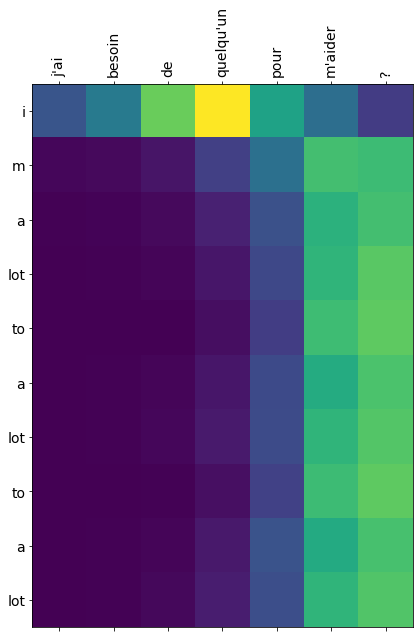

In [41]:
attn_weights = attn_weights[:len(pred.split(' ')), :len(sentence.split(' '))]
plot_attention(attn_weights, sentence.split(), pred.split())

### Conclusion.
We have learnt how to create an Encoder, Decoder Model with Attention for Neural Machine Translation task.

**Note in this notebook we did not focus much on the translations because we did not give the model enough time to train.In the next notebook we are going to give the model time to train.**

### Refs
* [Paperspace blog post](https://blog.paperspace.com/neural-machine-translation-with-tensorflow/)